In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np 
import seaborn as sns
import scipy.stats as st
import statistics
import math

df = pd.read_csv('DPIC Execution Database - U.S. Executions.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Step 2

# Q2

def get_volunteer_value(x):
    if(x['Execution Volunteer'] == 'yes'):
        return 1
    else: 
        return 0
    
def get_juvenile_value(x):
    if(x.Juvenile == 'yes'):
        return 1
    else: 
        return 0
    
# Create discrete columns for our dependent variables
df['volunteerDiscrete'] = df.apply(lambda row: get_volunteer_value(row), axis=1)
df['juvenileDiscrete'] = df.apply(lambda row: get_juvenile_value(row), axis=1)

In [3]:
# Step 2

# Q3

#Need to move outliers such as " Male" and "White " into their correct categories because of the whitespaces
df.loc[df['Sex'] == " Male", 'Sex'] = "Male"
df.loc[df['Race'] == "White ", 'Race'] = "White"
        

print(df['Race'].value_counts())
print("")
print(df['Sex'].value_counts())

White                               869
Black                               532
Latinx                              130
American Indian or Alaska Native     20
Asian                                 7
Other Race                            3
Name: Race, dtype: int64

Male      1543
Female      18
Name: Sex, dtype: int64


Text(0.5, 1.0, 'Execution Volunteer by Race')

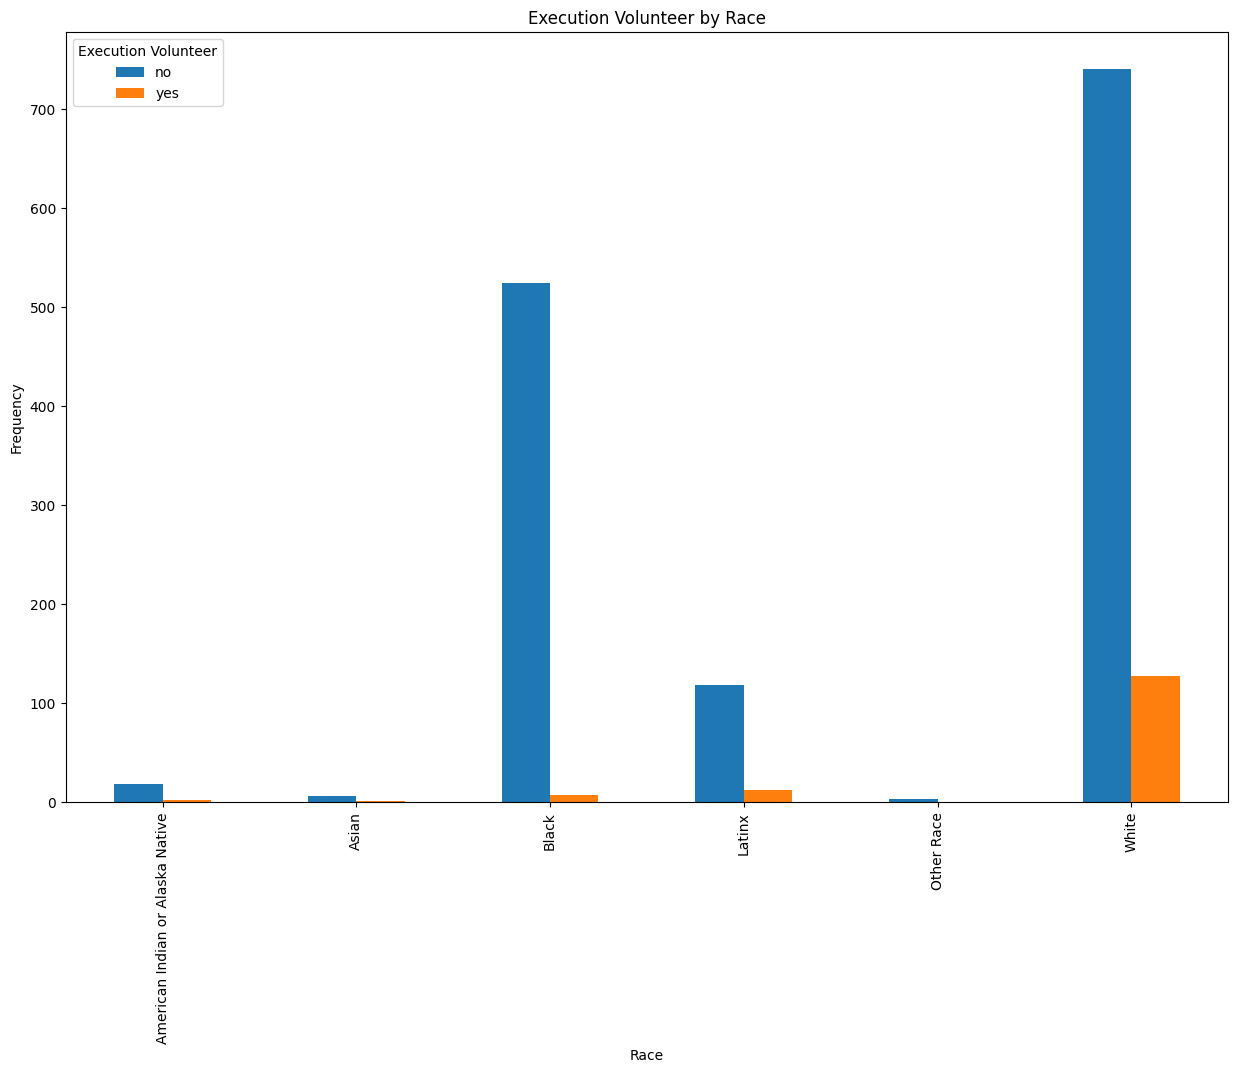

In [4]:
# Step 2

# Q4

df.groupby(['Race', 'Execution Volunteer']).Race.count().unstack().plot(kind='bar', figsize=(15,10))
##################


plt.xlabel("Race")
plt.ylabel('Frequency')
plt.title("Execution Volunteer by Race")

Text(0.5, 1.0, 'Juveniles by Race')

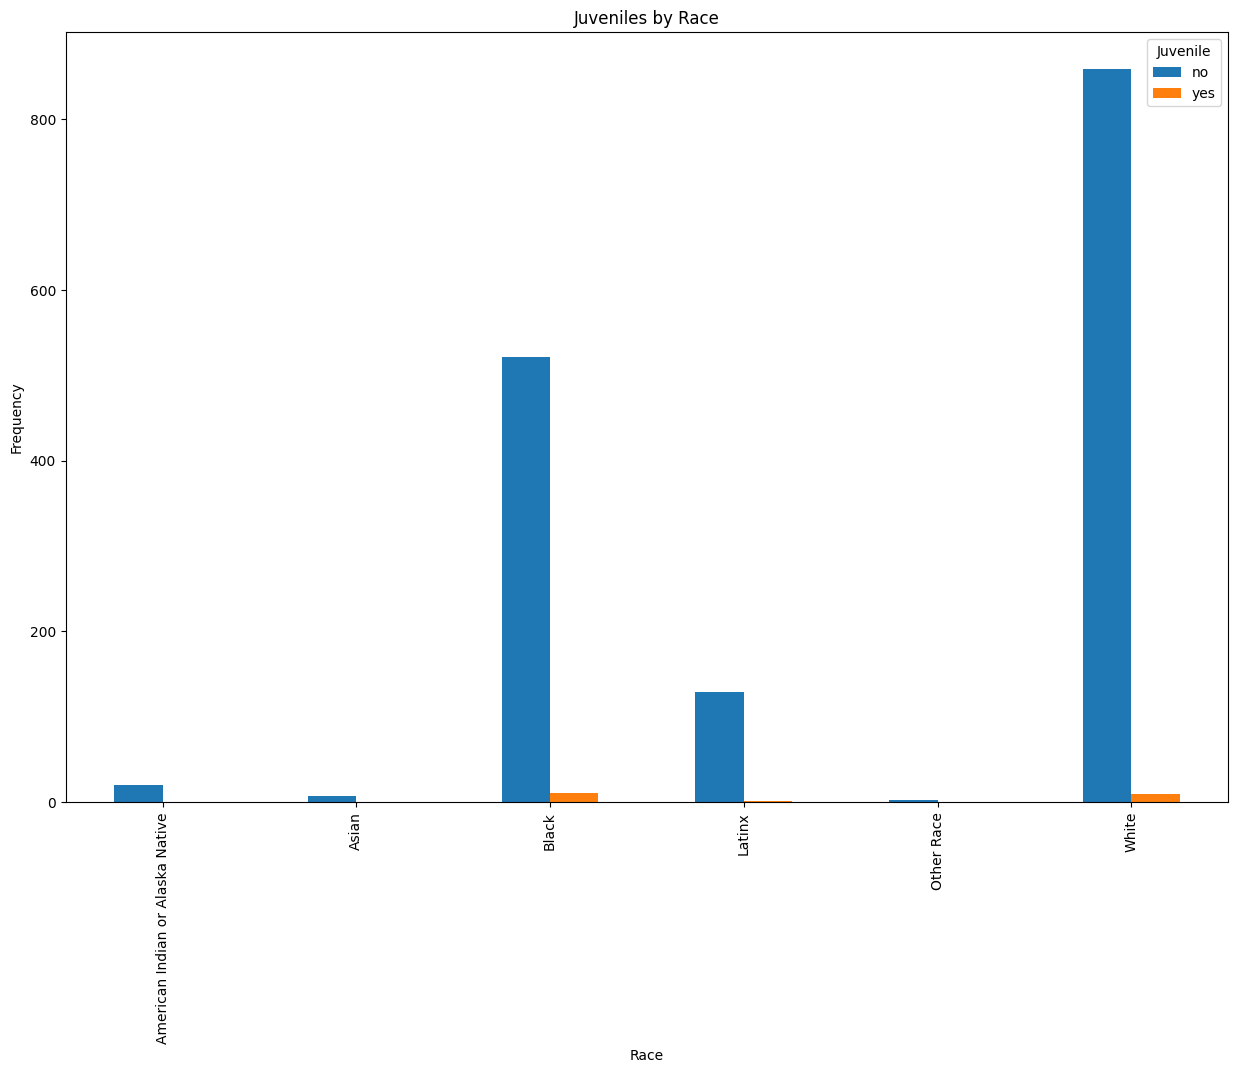

In [5]:
df.groupby(['Race', 'Juvenile']).Race.count().unstack().plot(kind='bar', figsize=(15,10))
##################


plt.xlabel("Race")
plt.ylabel('Frequency')
plt.title("Juveniles by Race")

Text(0.5, 1.0, 'Execution Volunteer by Sex')

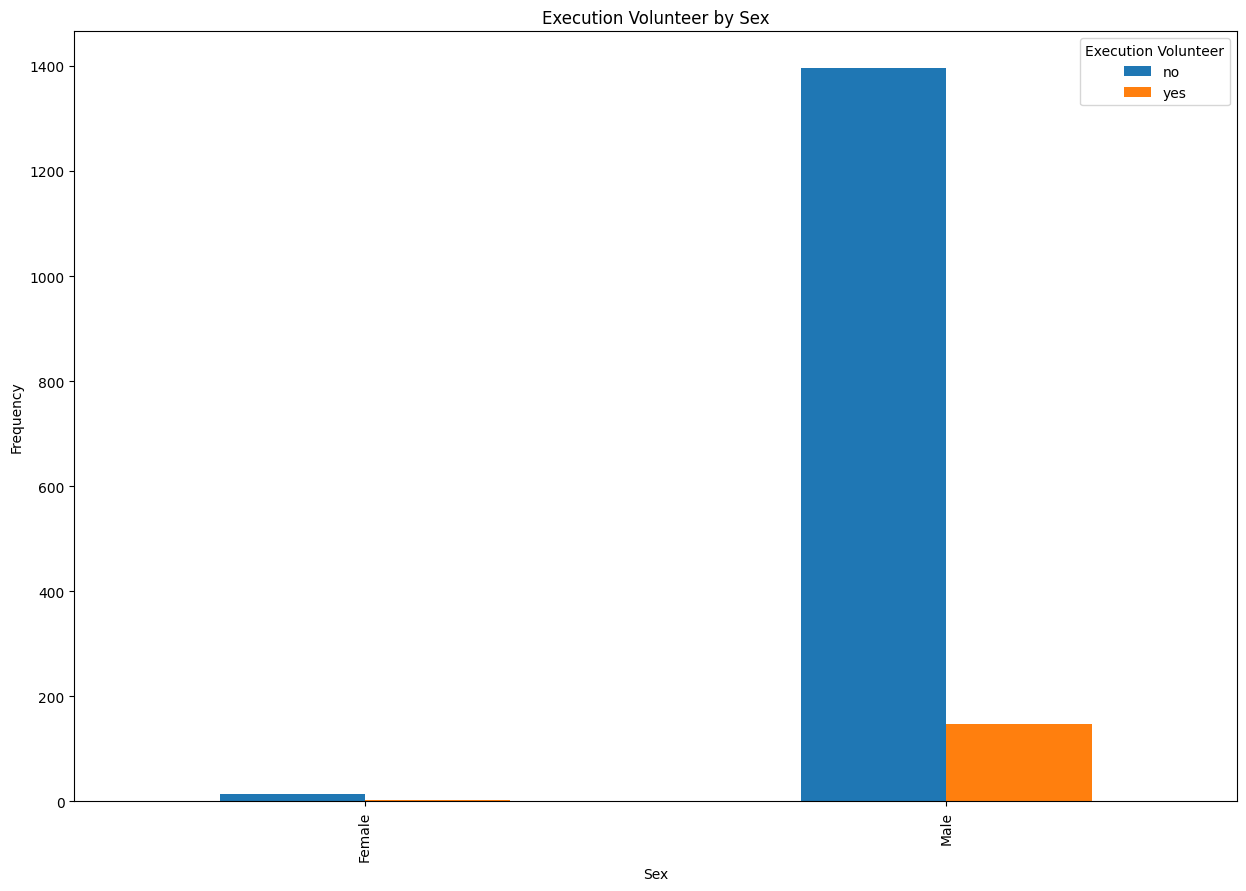

In [6]:
df.groupby(['Sex', 'Execution Volunteer']).Race.count().unstack().plot(kind='bar', figsize=(15,10))
##################


plt.xlabel("Sex")
plt.ylabel('Frequency')
plt.title("Execution Volunteer by Sex")

Text(0.5, 1.0, 'Juvenile by Sex')

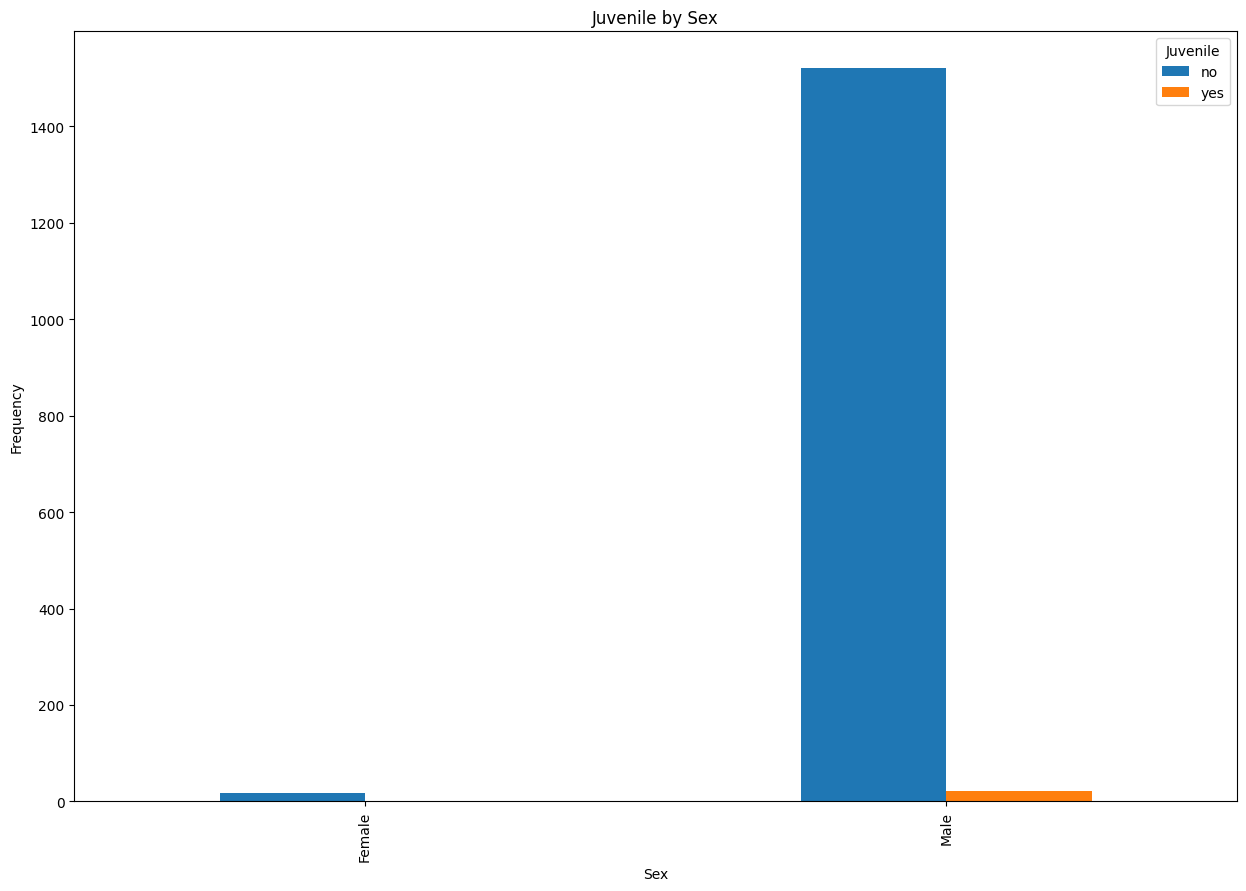

In [7]:
df.groupby(['Sex', 'Juvenile']).Race.count().unstack().plot(kind='bar', figsize=(15,10))
##################


plt.xlabel("Sex")
plt.ylabel('Frequency')
plt.title("Juvenile by Sex")

In [14]:
#@title Install the What-If Tool widget if running in Colab {display-mode: "form"}

# If running in Colab then pip install, otherwise no need.
try:
  import google.colab
  !pip install --upgrade witwidget
except Exception:
  pass

In [15]:
# Step 3

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#@title Define helper functions {display-mode: "form"}

import pandas as pd
import numpy as np
import tensorflow as tf
import functools

# Creates a tf feature spec from the dataframe and columns specified.
def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

# Creates simple numeric and categorical feature columns from a feature spec and a
# list of columns from that spec to use.
#
# NOTE: Models might perform better with some feature engineering such as bucketed
# numeric columns and hash-bucket/embedding columns for categorical features.
def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(df[col].unique()))))
    return ret

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.io.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
        examples.append(example)
    return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

print("hola")

hola


In [16]:
#@title Read training dataset from CSV {display-mode: "form"}

import pandas as pd

# Set the path to the CSV containing the dataset to train on.
csv_path = 'execution.csv'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Execution Volunteer",
"Number of Victims",
"Juvenile",
"First Name",
"Last Name",
"Middle Name(s)",
"Suffix",
"Race",
"Sex",
"Region",
"Country",
"State",
"Foreign National",
"Execution Date",
"Number of White Male Victims",
"Number of Black Male Victims",
"Number of Latino Male Victims",
"Number of Asian Male Victims",
"Number of Native American Male Victims",
"Number of Other Race Male Victims",
"Number of White Female Victims",
"Number of Black Female Victims",
"Number of Latino Female Victims",
"Number of Asian Female Victims",
"Number of American Indian or Alaska Native Female Victims",
"Number of Other Race Female Victims",
"Victim(s) Race(s)"]

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df

,Execution Volunteer,Number of Victims,Juvenile,First Name,Last Name,Middle Name(s),Suffix,Race,Sex,Region,...,Number of Asian Male Victims,Number of Native American Male Victims,Number of Other Race Male Victims,Number of White Female Victims,Number of Black Female Victims,Number of Latino Female Victims,Number of Asian Female Victims,Number of American Indian or Alaska Native Female Victims,Number of Other Race Female Victims,Victim(s) Race(s)
0,yes,1,no,Gary,Gilmore,Mark,-,White,Male,West,...,0,0,0,0,0,0,0,0,0,White
1,no,1,no,John,Spenkelink,-,-,White,Male,South,...,0,0,0,0,0,0,0,0,0,White
2,yes,1,no,Jesse,Bishop,-,-,White,Male,West,...,0,0,0,0,0,0,0,0,0,White
3,yes,4,no,Steven,Judy,-,-,White,Male,Midwest,...,0,0,0,2,0,0,0,0,0,White
4,yes,1,no,Frank,Coppola,-,-,White,Male,South,...,0,0,0,0,0,0,0,0,0,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,no,1,no,Kevin,Johnson,-,-,Black,Male,Midwest,...,0,0,0,0,0,0,0,0,0,White
1557,no,1,no,Thomas,Edwin,Loden,Jr.,White,Male,South,...,0,0,0,1,0,0,0,0,0,White
1558,no,1,no,Amber,McLaughlin,-,-,White,Female,Midwest,...,0,0,0,1,0,0,0,0,0,White
1559,no,1,no,Robert,Fratta,Alan,-,White,Male,South,...,0,0,0,1,0,0,0,0,0,White


In [17]:
#@title Specify input columns and column to predict {display-mode: "form"}
import numpy as np

# Set the column in the dataset you wish for the model to predict
label_column = 'Execution Volunteer'

# Make the label column numeric (0 and 1), for use in our model.
# In this case, examples with a target value of '>50K' are considered to be in
# the '1' (positive) class and all other examples are considered to be in the
# '0' (negative) class.
make_label_column_numeric(df, label_column, lambda val: val == 'Voluntold')

# Set list of all columns from the dataset we will use for model input.
input_features = [
  "Execution Volunteer",
"Number of Victims",
"Juvenile",
"First Name",
"Last Name",
"Middle Name(s)",
"Suffix",
"Race",
"Sex",
"Region",
"Country",
"State",
"Foreign National",
"Execution Date",
"Victim(s) Race(s)"]
# Create a list containing all input features and the label column
features_and_labels = input_features + [label_column]

print('ni hao')

ni hao


In [18]:
#@title Convert dataset to tf.Example protos {display-mode: "form"}

examples = df_to_examples(df)

In [19]:
#@title Create and train the classifier {display-mode: "form"}

num_steps = 5000  #@param {type: "number"}

# Create a feature spec for the classifier
feature_spec = create_feature_spec(df, features_and_labels)

# Define and train the classifier
train_inpf = functools.partial(tfexamples_input_fn, examples, feature_spec, label_column)
classifier = tf.estimator.LinearClassifier(
    feature_columns=create_feature_columns(input_features, feature_spec))
classifier.train(train_inpf, steps=num_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/hl/xtgpjq755plc0yptwxhbcs3c0000gn/T/tmp9gioota8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


ValueError: in user code:

    File "/Users/andyuyeda/Library/Python/3.8/lib/python/site-packages/tensorflow_estimator/python/estimator/canned/linear.py", line 1668, in call  *
        return self.layer(features)
    File "/Users/andyuyeda/Library/Python/3.8/lib/python/site-packages/tensorflow_estimator/python/estimator/canned/linear.py", line 1496, in call  *
        weighted_sum = fc_v2._create_weighted_sum(  # pylint: disable=protected-access
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/contextlib.py", line 113, in __enter__
        return next(self.gen)

    ValueError: 'Execution Date_lookup' is not a valid scope name. A scope name has to match the following pattern: ^[A-Za-z0-9_.\\/>-]*$
